In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# 探討：
* 四種出場條件下的獲利情況
* 因為沒資料而出場的要另外考量

In [2]:
trade_result = pd.read_csv('trade_result_finance_ASR_2_Num_10.csv')
trade_result['date_in'] = trade_result['date_in'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
trade_result['date_out'] = trade_result['date_out'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
trade_result['stock_1_profit'] = None
trade_result['stock_2_profit'] = None
trade_result['net_profit'] = None
trade_result.head()

,Unnamed: 0,ADF_statistic_in,ADF_statistic_out,ASR_in,ASR_out,PS_in,PS_out,date_in,date_out,hedge_ratio_in,...,stock_1_log_in,stock_1_log_out,stock_1_out,stock_2_in,stock_2_log_in,stock_2_log_out,stock_2_out,stock_1_profit,stock_2_profit,net_profit
0,"(2809, 2816)",-3.432056,-2.438056,2.034846,4.666542,2.765886,1.963620,2000-11-13,2000-12-01,1.348488,...,1.147402,1.054312,2.87,57.64,4.054217,4.214938,67.69,None,None,None
1,"(2809, 2812)",-2.709090,-2.056534,3.336841,4.090072,2.350131,1.082889,2000-11-13,2000-12-04,1.157086,...,1.147402,1.050822,2.86,3.58,1.275363,1.316408,3.73,None,None,None
2,"(2816, 2845)",-2.952143,-2.615544,2.810982,4.078891,2.675328,2.375831,2000-12-01,2000-12-04,0.793906,...,4.214938,4.311604,74.56,2.21,0.792993,0.792993,2.21,None,None,None
3,"(2812, 2845)",-3.217639,-3.202555,2.156350,0.044984,2.548881,0.024001,2000-11-27,2000-12-11,0.944363,...,1.220830,1.226712,3.41,2.11,0.746688,0.832909,2.30,None,None,None
4,"(2816, 2820)",-2.829861,NaN,2.789746,NaN,2.342916,NaN,2000-12-01,2000-12-11,0.587134,...,4.214938,NaN,78.27,1.74,0.553885,NaN,1.79,None,None,None


In [3]:
trade_result.groupby('reason').count()

,Unnamed: 0,ADF_statistic_in,ADF_statistic_out,ASR_in,ASR_out,PS_in,PS_out,date_in,date_out,hedge_ratio_in,...,stock_1_log_in,stock_1_log_out,stock_1_out,stock_2_in,stock_2_log_in,stock_2_log_out,stock_2_out,stock_1_profit,stock_2_profit,net_profit
reason,,,,,,,,,,,,,,,,,,,,,
cointegration_invalid,1079,1079,0,1079,0,1079,0,1079,1079,1079,...,1079,0,1079,1079,1079,0,1079,0,0,0
reversion,382,382,382,382,382,382,382,382,382,382,...,382,382,382,382,382,382,382,0,0,0
stop_loss,162,162,162,162,162,162,162,162,162,162,...,162,162,162,162,162,162,162,0,0,0
take_profit,540,540,540,540,540,540,540,540,540,540,...,540,540,540,540,540,540,540,0,0,0


In [4]:
cost_rate = 0.001425
tax_rate = 0.003

In [5]:
def calculate_profit(x):
    if x['spread_in'] > 0:
        # buy stock_1, short stock_2
        stock_1_profit = (
            x['stock_1_out'] - x['stock_1_in'] -
            cost_rate*(x['stock_1_in']+x['stock_1_out']) -
            tax_rate*(x['stock_1_out'])
        )*abs(x['hedge_ratio_in'])
        stock_2_profit = (
            x['stock_2_in'] - x['stock_2_out'] -
            cost_rate*(x['stock_2_in']+x['stock_2_out']) -
            tax_rate*(x['stock_2_out'])
        )*1000
    else:
        # short stock_1, buy stock_2
        stock_1_profit = (
            x['stock_1_in'] - x['stock_1_out'] -
            cost_rate*(x['stock_1_in']+x['stock_1_out']) -
            tax_rate*(x['stock_1_out'])
        )*abs(x['hedge_ratio_in'])
        stock_2_profit = (
            x['stock_2_out'] - x['stock_2_in'] -
            cost_rate*(x['stock_2_in']+x['stock_2_out']) -
            tax_rate*(x['stock_2_out'])
        )*1000

    total_profit = stock_1_profit + stock_2_profit
    
    return [stock_1_profit, stock_2_profit, total_profit]

In [6]:
trade_result = trade_result.copy()
for i in range(len(trade_result)):
    temp_result = trade_result.iloc[i]
    trade_result.loc[i, ['stock_1_profit', 'stock_2_profit', 'net_profit']] = calculate_profit(temp_result)

In [7]:
trade_result.reason.unique()

array(['stop_loss', 'reversion', 'cointegration_invalid', 'take_profit'], dtype=object)

In [26]:
def plot_equity_curve(select_result = None, figsize=(16, 8)):
    if select_result == None:
        temp_result = trade_result
        title = 'total result'
    else: 
        temp_result = trade_result[trade_result.reason.isin(select_result)]
        title = str(select_result)
    accumulate_profit = temp_result.net_profit.values.cumsum()

    # 找出創新高的index(要畫綠點)
    new_highest_index = []
    for i in range(len(accumulate_profit)):
        current_accumulate_profit = accumulate_profit[i]
        if i == 0:
            new_highest = accumulate_profit[i]
        if (current_accumulate_profit > new_highest) and (current_accumulate_profit > 0):
            new_highest = current_accumulate_profit
            new_highest_index.append(i)

    # 找出drawdown
    drawdown = []
    for i in range(len(accumulate_profit)):
        current_accumulate_profit = accumulate_profit[i]
        if i == 0:
            new_highest = accumulate_profit[i]
            drawdown.append(0)
        else:
            if (current_accumulate_profit > new_highest) and (current_accumulate_profit > 0):
                new_highest = current_accumulate_profit 
            if (current_accumulate_profit < new_highest):
                drawdown.append(current_accumulate_profit-new_highest)
            else:
                drawdown.append(0)
    
    print('   Net profit: ', accumulate_profit[-1])
    print('   MDD: ', min(drawdown))
    print('   Calmar ratio: ', accumulate_profit[-1]/abs(min(drawdown)))
    

    plt.style.use('seaborn')
    plt.figure(figsize=figsize)
    # 權益曲線
    plt.plot(accumulate_profit, c='black')
    # 創新高的點
    plt.scatter(new_highest_index,
                accumulate_profit[new_highest_index], c='#02ff0f', s=70)
#     plt.plot(drawdown, c='red')
    plt.title('Equity Curve - {}'.format(title), size=20)
    plt.xlabel('Trade Number', size=15)
    plt.ylabel('NTD', size=15)
    plt.xticks(size=13)
    plt.yticks(size=13);

   Net profit:  -161006.863024
   MDD:  -151255.47101
   Calmar ratio:  -1.06446968132


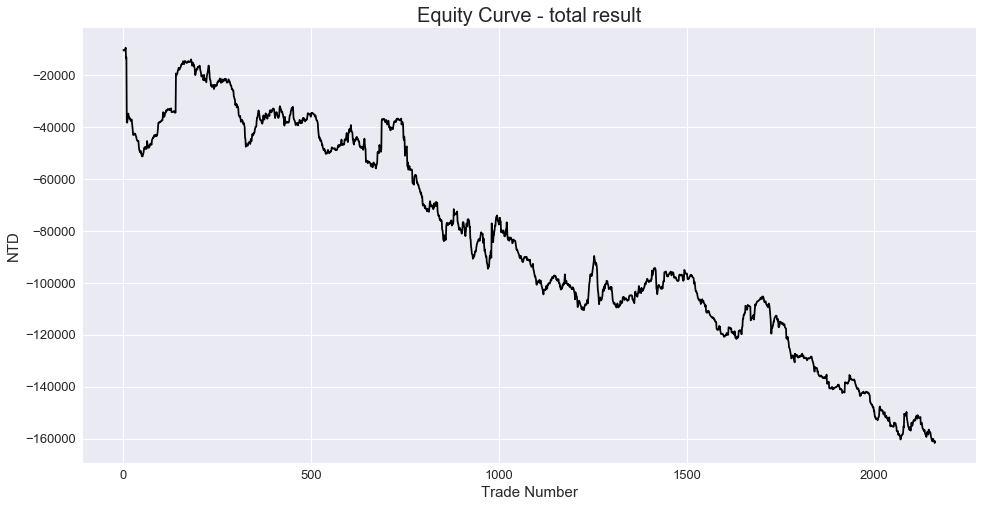

In [27]:
plot_equity_curve(None)

   Net profit:  87222.8707818
   MDD:  -11249.2110391
   Calmar ratio:  7.75368783452


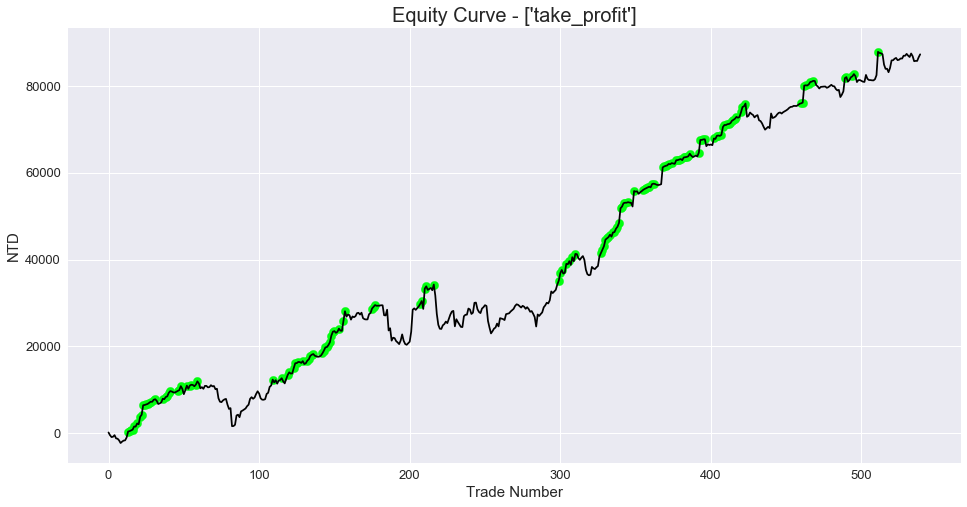

In [29]:
plot_equity_curve(['take_profit'])

   Net profit:  140514.278454
   MDD:  -7048.88238774
   Calmar ratio:  19.9342634371


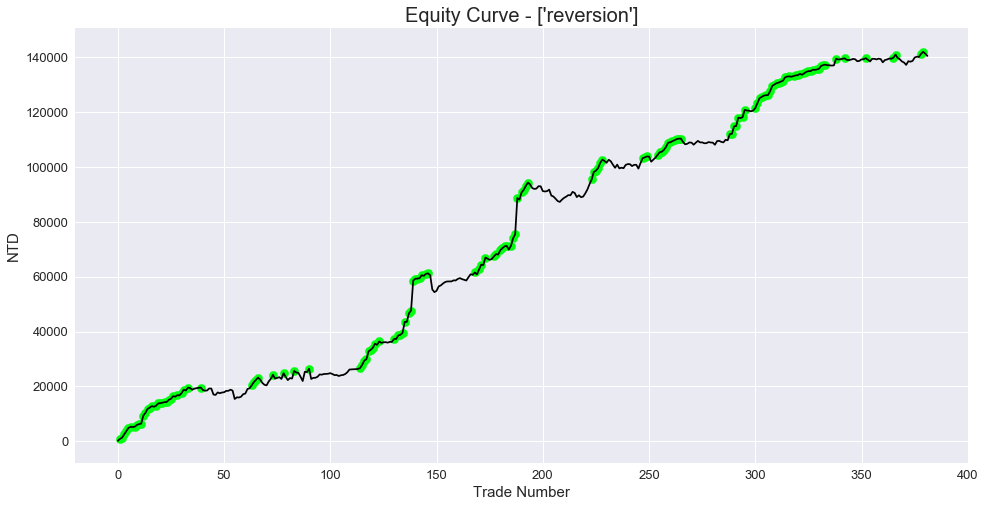

In [30]:
plot_equity_curve(['reversion'])

   Net profit:  -71795.5602588
   MDD:  -62723.0445938
   Calmar ratio:  -1.14464405744


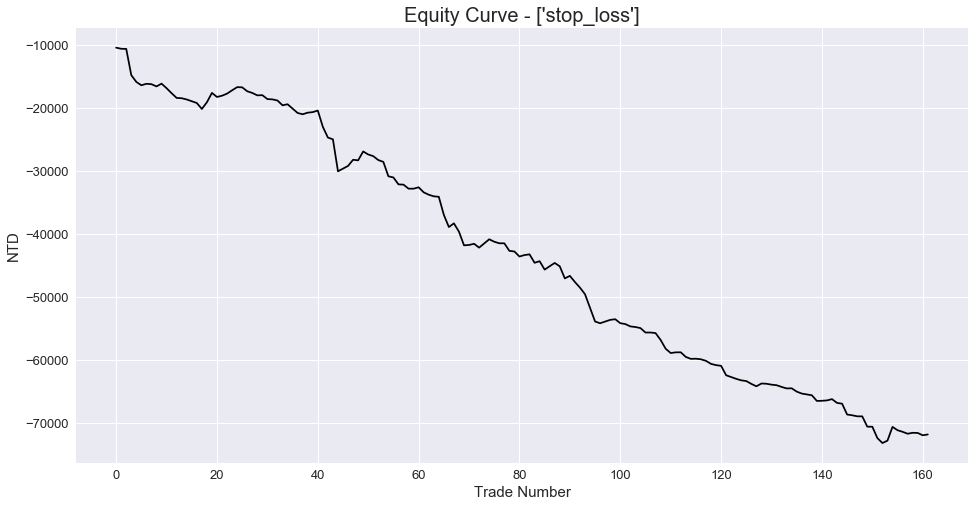

In [31]:
plot_equity_curve(['stop_loss'])

   Net profit:  -316948.452001
   MDD:  -317090.877017
   Calmar ratio:  -0.999550838494


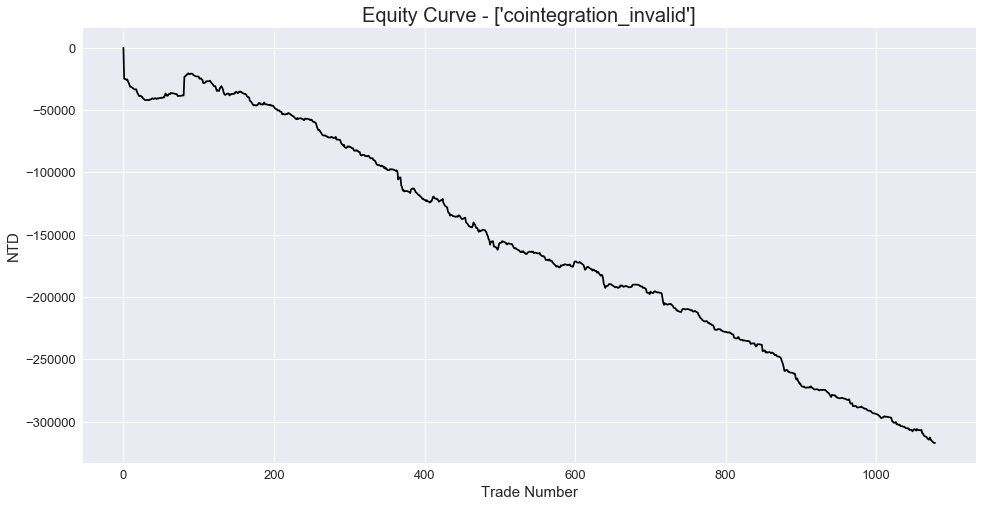

In [32]:
plot_equity_curve(['cointegration_invalid'])

In [33]:
win_loss_ratio = np.mean(trade_result[trade_result.net_profit > 0].net_profit) / np.mean(trade_result[trade_result.net_profit < 0].net_profit)
winning_rate = len(trade_result[trade_result.net_profit > 0]) / len(trade_result)
print('   Expection: ', abs(win_loss_ratio)*winning_rate - (1-winning_rate))

   Expection:  -0.111990952345
